In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [3]:
#open NVIDEA Yahoo Finance historical data
df = pd.read_csv('NVDA.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.016388,41777200
1,2023-06-09,390.369995,397.109985,385.670013,387.700012,387.615814,42722000
2,2023-06-12,392.000000,395.299988,386.179993,394.820007,394.734253,38870100
3,2023-06-13,401.859985,411.010010,397.399994,410.220001,410.130920,61320800
4,2023-06-14,408.239990,430.000000,405.519989,429.970001,429.876617,74046500


<function matplotlib.pyplot.show(close=None, block=None)>

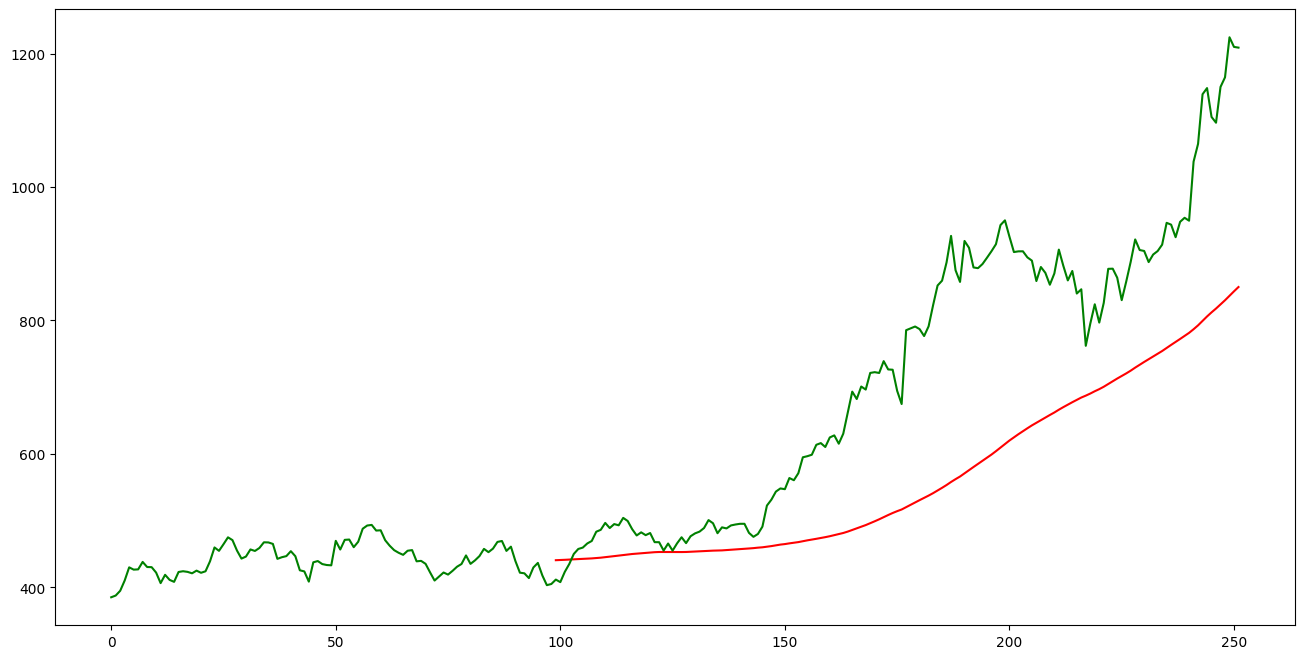

In [4]:
#calculate rolling mean
df_100_days = df.Close.rolling(100).mean()

#plot data for comparison
plt.figure(figsize=(16,8))
plt.plot(df_100_days, 'r')
plt.plot(df.Close, 'g')
plt.show

In [9]:
#clearly rolling mean does not give an accurate representation of the stock for 100 days sample size
#so let us create a model to accurately predict the stock 

#first, clean the data of any NA values
orig = df.shape[0]
df.dropna(inplace=True)

#check for how many values disapeared 

count = orig - df.shape[0]

print(count)

#clearly no values were dropped from our dataset

0


In [10]:
#seperate data into training set and test set for our model

df_train = pd.DataFrame(df.Close[0: int(len(df)*0.8)])
df_test = pd.DataFrame(df.Close[int(len(df)*0.8): len(df)])

df_train.shape[0]
df_test.shape[0]


51

In [11]:
# This code block is responsible for reshaping the training data for the LSTM model.

scaler = MinMaxScaler(feature_range=(0,1))

 #It converts the x_train list into a 3D array which is the required input shape for LSTM network.
# The first dimension is the number of records or batches, the second dimension is the number of time steps,
# and the third dimension is the number of features per step (in this case, just the scaled 'Close' price).
df_train_scale = scaler.fit_transform(df_train)

x_train = []
y_train = []

for i in range(100, df_train_scale.shape[0]):
    x_train.append(df_train_scale[i-100:i])
    y_train.append(df_train_scale[i,0])



In [12]:
#we append the data as an array since 

x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# Define the model
model = Sequential()

# List of LSTM units and whether they return sequences
lstm_layers = [
    (50, True),
    (60, True),
    (80, True),
    (120, False)  # The last layer does not return sequences
]

# List of dropout rates
dropout_rates = [0.2, 0.3, 0.4, 0.5]

# Initial input shape for the first LSTM layer
input_shape = (x_train.shape[1], 1)

# Adding LSTM and Dropout layers using a loop
for i, (units, return_sequences) in enumerate(lstm_layers):
    if i == 0:
        # First layer needs to specify the input shape
        model.add(LSTM(units=units, activation='relu', return_sequences=return_sequences, input_shape=input_shape))
    else:
        model.add(LSTM(units=units, activation='relu', return_sequences=return_sequences))
    
    model.add(Dropout(dropout_rates[i]))

# Add the final Dense layer
model.add(Dense(units=1))



In [14]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train,y_train, epochs= 50, batch_size=32, verbose=1)

Epoch 1/50
4/4 [==============================] - 2s 90ms/step - loss: 0.2407
Epoch 2/50
4/4 [==============================] - 0s 89ms/step - loss: 0.1760
Epoch 3/50
4/4 [==============================] - 0s 88ms/step - loss: 0.0667
Epoch 4/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0498
Epoch 5/50
4/4 [==============================] - 0s 90ms/step - loss: 0.0382
Epoch 6/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0261
Epoch 7/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0247
Epoch 8/50
4/4 [==============================] - 0s 88ms/step - loss: 0.0259
Epoch 9/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0262
Epoch 10/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0164
Epoch 11/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0161
Epoch 12/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0161
Epoch 13/50
4/4 [==============================] - 0s 87ms/st

In [23]:
model.summary()

#Note that when running the summary, there seems to be no parameters passed within the dropout, this could be 
# because the data for the NVIDEA stock did not require a dropout to prevent overfitting since the sample size is small



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [25]:
#let us check each layer and check if they are dropout layers or not: 

# Check where dropout is used
dropout_layers = []
for i, layer in enumerate(model.layers):
  if isinstance(layer, Dropout):
    dropout_rate = layer.rate  # Access the dropout rate directly
    dropout_layers.append((i, dropout_rate))

if dropout_layers:
  print("Dropout is used in the following layers:")
  for index, rate in dropout_layers:
    print(f"  - Layer {index+1} (after LSTM {index}) with dropout rate: {rate}")
else:
  print("Dropout is not used in the model.")


  #Clearly the dropout rates are being used in the model and are adjusted in the layers shown below.
  #model.summary() does not account for if dropout was used or not so the parameter numbers will default to 0

Dropout is used in the following layers:
  - Layer 2 (after LSTM 1) with dropout rate: 0.2
  - Layer 4 (after LSTM 3) with dropout rate: 0.3
  - Layer 6 (after LSTM 5) with dropout rate: 0.4
  - Layer 8 (after LSTM 7) with dropout rate: 0.5


In [26]:
#testing model using last 100 days
past_100_days = df_train.tail(100)

df_test = pd.concat([past_100_days, df_test], ignore_index=True)
df_test

,Close
0,423.250000
1,435.059998
2,450.049988
3,457.510010
4,459.549988
...,...
146,1150.000000
147,1164.369995
148,1224.400024
149,1209.979980


In [27]:
#we create a tesr scale similar to the 3D array we appending in the training data so our model can run the prediction

df_test_scale = scaler.fit_transform(df_test)


x_test = []
y_test = []

for i in range(100, df_test_scale.shape[0]):
    x_test.append(df_test_scale[i-100:i])
    y_test.append(df_test_scale[i,0])


x_test, y_test = np.array(x_test), np.array(y_test)

In [29]:
#run the model against the training data so we can get results of our test data of the 100 days
y_prediction = model.predict(x_train)
y_prediction

#note that when we run these values we need to multiple them by a scaler value to transform them back into their coordinates


4/4 [==============================] - 0s 38ms/step


array([[0.13613704],
       [0.13584848],
       [0.13554901],
       [0.13525191],
       [0.1349732 ],
       [0.13473013],
       [0.13453752],
       [0.13441001],
       [0.13436209],
       [0.13442132],
       [0.13462949],
       [0.13505396],
       [0.13577372],
       [0.13686408],
       [0.13838847],
       [0.14043146],
       [0.1430956 ],
       [0.14639264],
       [0.15023935],
       [0.15450494],
       [0.15904203],
       [0.16371775],
       [0.16833466],
       [0.17269221],
       [0.17655635],
       [0.17976862],
       [0.18219954],
       [0.18383628],
       [0.18476716],
       [0.18508732],
       [0.18493327],
       [0.18446146],
       [0.18383124],
       [0.1832031 ],
       [0.18276255],
       [0.18267602],
       [0.18300468],
       [0.18379483],
       [0.185052  ],
       [0.1867708 ],
       [0.1889396 ],
       [0.1915379 ],
       [0.19453114],
       [0.19780055],
       [0.20116243],
       [0.20444658],
       [0.20757078],
       [0.210

In [30]:
#we create a scale value to multiply

scale = 1/scaler.scale_

In [31]:
y_prediction = y_prediction*scale
y_train= y_train*scale

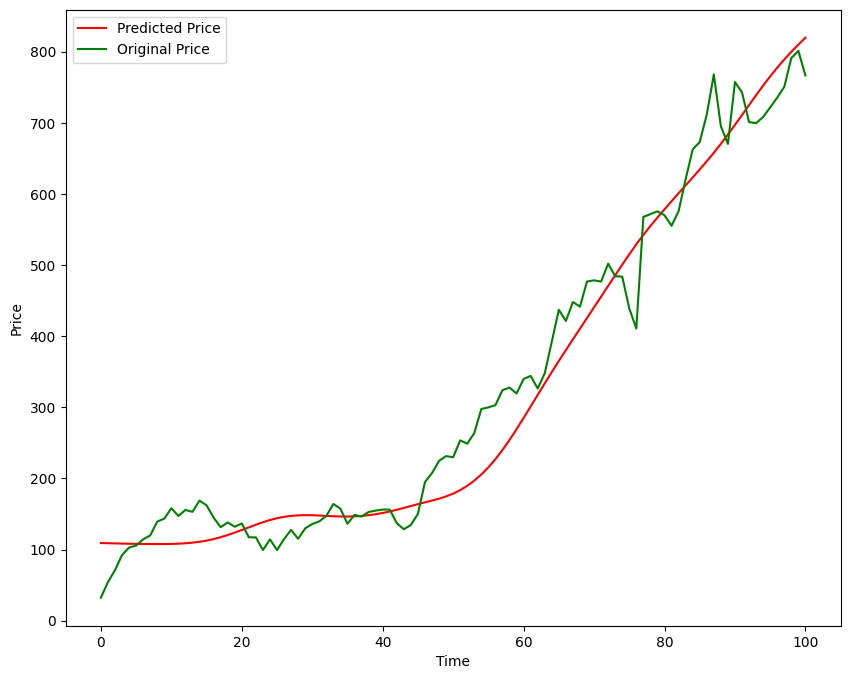

In [32]:
plt.figure(figsize=(10,8))
plt.plot(y_prediction, 'r', label = 'Predicted Price')
plt.plot(y_train, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_train,y_prediction)

RMSE = math.sqrt(MSE)

print(RMSE)

42.523560742338525


In [96]:
model.save('NVIDEA Stock Prediction Model.keras')